In [111]:
import torch
import numpy as np
import matplotlib.pyplot as plt


from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import matplotlib.image as image

from mlcolvar.utils.plot import paletteFessa
reference_committor_model = torch.jit.load('../3_committor/model_committor_reference.pt').to(torch.device('cpu'))

#### Trivial sensitivity analysis

Class 0 dataframe shape:  (8000, 17)
Class 1 dataframe shape:  (8000, 17)

 - Loaded dataframe (16000, 17): ['time', 'p.x', 'p.y', 'p.z', 'mueller', 'potential.bias', 'potential.mueller_bias', 'lwall_x.bias', 'lwall_x.force2', 'uwall_x.bias', 'uwall_x.force2', 'lwall_y.bias', 'lwall_y.force2', 'uwall_y.bias', 'uwall_y.force2', 'walker', 'labels']
 - Descriptors (16000, 2): ['p.x', 'p.y']


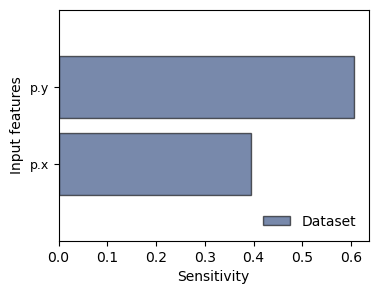

In [9]:
n_states = 2
from mlcolvar.utils.io import create_dataset_from_files

filenames = ["../1_enhanced_sampling/simulations/unbiased_sims/A/COLVAR",
             "../1_enhanced_sampling/simulations/unbiased_sims/B/COLVAR",]

dataset, dataframe = create_dataset_from_files(file_names=filenames,
                                               create_labels = True,
                                               filter_args={'regex': 'p.x|p.y'},
                                               return_dataframe=True,
                                               stop = 8000,
                                               stride=1)


from mlcolvar.explain import sensitivity_analysis

trained_model = torch.jit.load('../3_committor/models/model_0_q.pt')

fig, ax = plt.subplots(1,1,figsize=(4,3))
results = sensitivity_analysis(trained_model,
                               dataset,
                               metric="mean_abs_val",   # metric to use to compute the sensitivity per feature (e.g. mean absolute value or root mean square)
                               feature_names=None,      # by default, they will be taken from `dataset.feature_names`
                               per_class=False,         # whether to do per-class statistics
                               plot_mode='barh',
                               ax = ax)          

In [100]:
filenames = ['https://raw.githubusercontent.com/alphatestK/Committor/main/chignolin/data/COLVAR.9.u',
             'https://raw.githubusercontent.com/alphatestK/Committor/main/chignolin/data/COLVAR.9.f']   

dataset, dataframe = create_dataset_from_files(file_names=filenames,
                                               create_labels = True,
                                               filter_args={'regex' : 'x[1-9]|x[1-4][0-9]'},
                                               return_dataframe=True,
                                               stride=1)

Class 0 dataframe shape:  (40001, 140)
Class 1 dataframe shape:  (40001, 140)

 - Loaded dataframe (80002, 140): ['time', 'rmsd_ca', 'end', 'ene', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'p1.a', 'p1.b', 'p1.c', 'p2.a', 'p2.b', 'p2.c', 'p3.a', 'p3.b', 'p3.c', 'p4.a', 'p4.b', 'p4.c', 'p5.a', 'p5.b', 'p5.c', 'p6.a', 'p6.b', 'p6.c', 'p7.a', 'p7.b', 'p7.c', 'p8.a', 'p8.b', 'p8.c', 'p9.a', 'p9.b', 'p9.c', 'p10.a', 'p10.b', 'p10.c', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'cont15', 'cont16', 'cont17', 'cont18', 'cont19', 'cont20', 'cont21', 'cont22', 'cont23', 'cont24', 'cont25', 'cont26', 'cont27', 'cont28', 'cont29', 'cont30', 'cont31', 'co

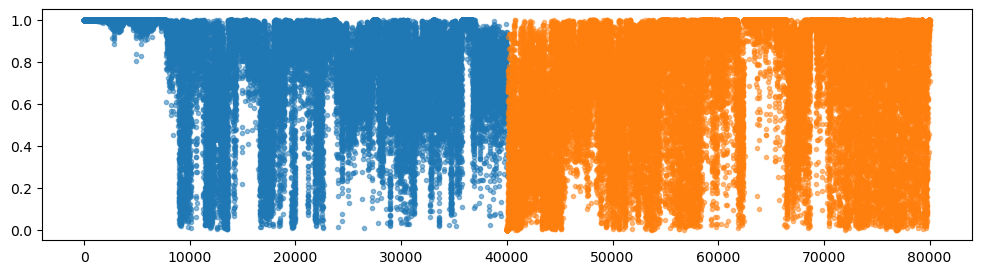

In [104]:
model = torch.jit.load('model_chignolin.pt').to(torch.device('cpu')).to(torch.float32)
dataframe['model_q'] = model(dataset['data']).detach().numpy()

fig, ax = plt.subplots(1,1,figsize=(12,3))
aux = dataframe.loc[dataframe.labels==0]
plt.plot(aux['model_q'], '.', alpha=0.5)
aux = dataframe.loc[dataframe.labels==1]
plt.plot(aux['model_q'], '.', alpha=0.5)

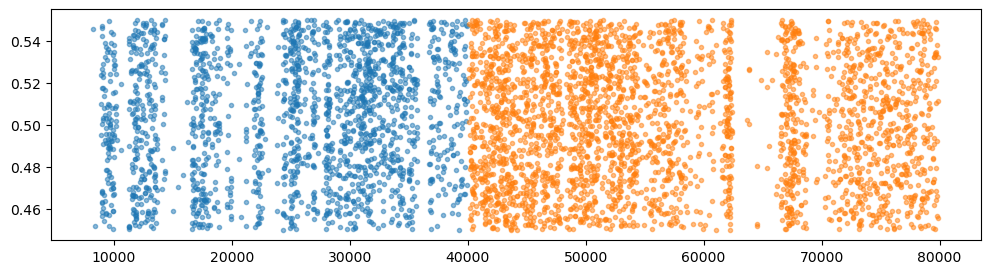

In [105]:
from mlcolvar.data import DictDataset

mask = np.logical_and(dataframe['model_q'] > 0.45, dataframe['model_q'] < 0.55)
sub_dataframe = dataframe.loc[mask]
sub_dataset = DictDataset({'data' : torch.Tensor(sub_dataframe.filter(regex='x[1-9]|x[1-4][0-9]').values),
                           'labels' : torch.Tensor(sub_dataframe['labels'].values) })

fig, ax = plt.subplots(1,1,figsize=(12,3))
aux = sub_dataframe.loc[sub_dataframe.labels==0]
plt.plot(aux['model_q'], '.', alpha=0.5)
aux = sub_dataframe.loc[sub_dataframe.labels==1]
plt.plot(aux['model_q'], '.', alpha=0.5)

# Add clustering

# Chignolin sensitivity

Plotting only the first 15 features out of 45.


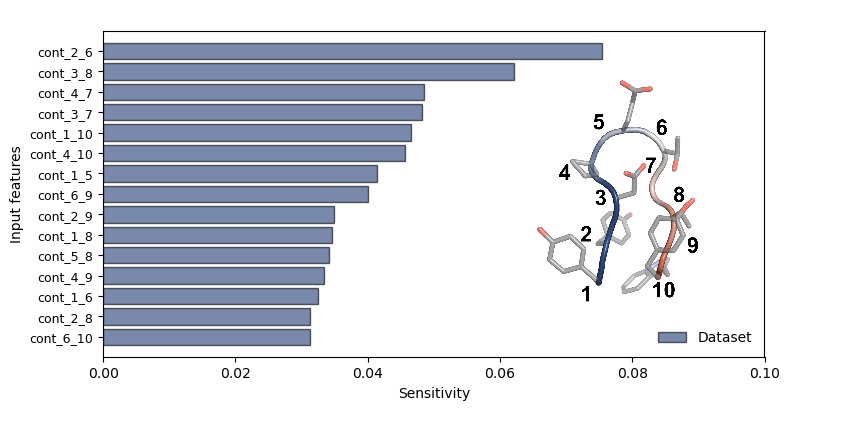

In [125]:
from mlcolvar.explain import plot_sensitivity

# create feature names for safety
feature_names = []
for i in range(10):
    for j in range(i+1, 10):
        feature_names.append(f"cont_{i+1}_{j+1}")

results = sensitivity_analysis(model,
                               sub_dataset,
                               metric="mean_abs_val",            # metric to use to compute the sensitivity per feature (e.g. mean absolute value or root mean square)
                               feature_names=feature_names,      # by default, they will be taken from `dataset.feature_names`
                               per_class=False,                  # whether to do per-class statistics
                               plot_mode=None)      


# plot
fig, ax = plt.subplots(1,1,figsize=(8,4))
plot_sensitivity(results, mode='barh', max_features=15, ax=ax)
ax.set_xlim(0, 0.1)

# add chignolin sketch for reference
B = image.imread('../figures/chignolin_labeled_atoms.png')
B_box = OffsetImage(B, zoom = 0.14)
B_ab = AnnotationBbox(B_box, (0.08, 6), frameon = False)
ax.add_artist(B_ab)

plt.tight_layout()
plt.show()